<a href="https://colab.research.google.com/github/yichun-hub/MaskRCNN_Road-Markings/blob/main/Mask_rcnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mask RCNN--Train on custom dataset




### VGG Image Annotator 標註影像
*   VIA網址：https://www.robots.ox.ac.uk/~vgg/software/via/via.html
*   標註使用教學：https://drive.google.com/file/d/1lkZObAiK6hAhVI736IHNZF542D1WzfbO/view?usp=sharing
*   匯出的json檔請取名為"via_region_data.json"



### Google Drive 檔案存取
1. 資料夾說明

*   mrcnn：Mask RCNN 官方code
*   train：所有訓練影像及訓練標註檔
*   val：所有測試影像及測試標註檔
*   sign_logs：訓練完model權重的放置資料夾





2. 使用Google Drive 共用資料：https://drive.google.com/drive/folders/1fIVAgRKLxSFhlWZ8gRL1TlnI0I9-o-Hj?usp=sharing


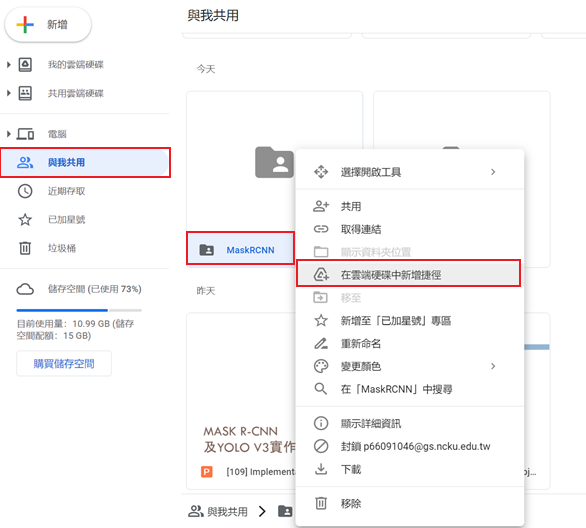

本範例將捷徑新增在: 我的雲端硬碟 > 新增捷徑

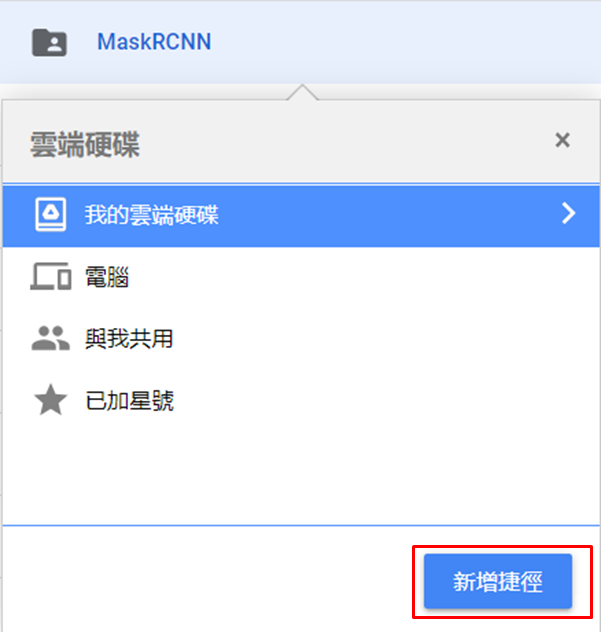

3. 掛載Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


測試連接google drive (使用上一步驟的共用資料捷徑)

In [ ]:
!ls /content/drive/MyDrive/MaskRCNN

mask_rcnn_coco.h5  mrcnn  sign_logs  train  val


### Tensorflow與Keras版本下載為指定版本
下載完後請確認print出來的版本，若非指定版本請重新執行


*   (中文版)執行階段-->重新啟動執行階段
*   (英文版)Runtime--> Restart Runtime


> 請務必確認tensorflow版本為1.X，keras=2.0.8才可執行本程式



In [ ]:
!pip3 uninstall keras-nightly
!pip3 uninstall -y tensorflow
!pip3 install keras==2.0.8
!pip3 install tensorflow==1.15.0
!pip3 install h5py==2.10.0

Found existing installation: tensorflow 2.8.0
Uninstalling tensorflow-2.8.0:
  Successfully uninstalled tensorflow-2.8.0
     |████████████████████████████████| 276 kB 5.1 MB/s 
  Attempting uninstall: keras
    Found existing installation: keras 2.8.0
    Uninstalling keras-2.8.0:
      Successfully uninstalled keras-2.8.0
     |████████████████████████████████| 412.3 MB 27 kB/s 
     |████████████████████████████████| 50 kB 6.3 MB/s 
     |████████████████████████████████| 503 kB 51.5 MB/s 
     |████████████████████████████████| 3.8 MB 51.1 MB/s 
  Created wheel for gast: filename=gast-0.2.2-py3-none-any.whl size=7554 sha256=fc2dd85e7e9423555c21e5f08e2242811f969b41555c572296046b005a8a8d94
  Stored in directory: /root/.cache/pip/wheels/21/7f/02/420f32a803f7d0967b48dd823da3f558c5166991bfd204eef3
Successfully built gast
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.8.0
    Uninstalling tensorflow-estimator-2.8.0:
      Successfully

In [ ]:
import tensorflow as tf
print(tf.__version__)

1.15.0


In [ ]:
import keras
print(keras.__version__)

Using TensorFlow backend.


2.0.8


####GPU配置確認

In [ ]:
# 查看是否有用到GPU
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
!nvidia-smi  ##查看GPU顯卡配置

Wed May  4 04:50:56 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   49C    P0    28W /  70W |    104MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### Mask RCNN
'##########'為要自行更改的地方

In [ ]:
import os
import sys
import json
import random
import math
import re
import time
import skimage.draw
import numpy as np
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Root directory of the project
ROOT_DIR = os.path.abspath("/content/drive/MyDrive/MaskRCNN") 

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn import utils
from mrcnn import visualize
from mrcnn.config import Config
from mrcnn.visualize import display_images
import mrcnn.model as modellib
from mrcnn.model import log

%matplotlib inline 

# Path to trained weights file
COCO_WEIGHTS_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")

In [ ]:
# Directory to save logs and model checkpoints, if not provided
# through the command line argument --logs
## logs 資料夾會存在colab裡
!mkdir logs ## 建立logs 資料夾
DEFAULT_LOGS_DIR = ("/content/logs")

Configurations

In [ ]:
class SignConfig(Config):
    """Configuration for training on the toy  dataset.
    Derives from the base Config class and overrides some values.
    """

    NAME = "sign"  ##########
    IMAGES_PER_GPU = 1
    # Number of classes (including background)
    NUM_CLASSES = 1 + 8  ##########+背景+類別

    STEPS_PER_EPOCH = 100 #100
    DETECTION_MIN_CONFIDENCE = 0.9

config = SignConfig()

**Dataset**

In [ ]:
class SignDataset(utils.Dataset):

    def load_sign(self, dataset_dir):
 
        # Add classes. 
        self.add_class("sign", 1, "traffic")
        self.add_class("sign", 2, "crossing")
        self.add_class("sign", 3, "speed")
        self.add_class("sign", 4, "slash")
        self.add_class("sign", 5, "road")
        self.add_class("sign", 6, "triangle")
        self.add_class("sign", 7, "arrow")
        self.add_class("sign", 8, "speedmark")
        #self.add_class("sign", 9, "新類別")##########


        dataset_dir = os.path.join(dataset_dir)

        annotations = json.load(open(os.path.join(dataset_dir, "via_region_data.json"))) #標註檔檔名
        annotations = list(annotations.values())  # don't need the dict keys

        # The VIA tool saves images in the JSON even if they don't have any
        # annotations. Skip unannotated images.
        annotations = [a for a in annotations if a['regions']]

        SumLable1=0
        SumLable11=0
        SumLable2=0


        # Add images
        for a in annotations:

            if type(a['regions']) is dict:
                polygons = [r['shape_attributes'] for r in a['regions'].values()]
            else:
                polygons = [r['shape_attributes'] for r in a['regions']] 

            rects = [r['shape_attributes'] for r in a['regions']]
            name = [s['region_attributes']for s in a['regions']]

######################################################################################

            sumn=0 
            delpolygon=[] 
            num_ids=[]

            for n in name:

            	try:
            
            		if n['name']=='traffic':
            			num_ids.append(1)

            		elif n['name']=='crossing':
            			num_ids.append(2)

            		elif n['name']=='speed':
            			num_ids.append(3)
               
            		elif n['name']=='slash':
            			num_ids.append(4)

            		elif n['name']=='road':
            			num_ids.append(5)
               
            		elif n['name']=='triangle':
            			num_ids.append(6)

            		elif n['name']=='arrow':
            			num_ids.append(7)
               
            		elif ((n['name']=='thirty') or (n['name']=='fourty') or (n['name']=='fifty') or 
                      (n['name']=='sixty') or (n['name']=='seventy')) :
            			num_ids.append(8)

            		#elif n['name']=='標記時的類別名稱':##########
            			#num_ids.append(4)

            		else:
            			delpolygon.append(sumn)


            	except:
            		pass
            	sumn+=1
            polygons=np.delete(polygons,delpolygon)


            image_path = os.path.join(dataset_dir, a['filename'])
            image = skimage.io.imread(image_path)
            height, width = image.shape[:2]

            idSUM=0
            delr=[]
            print(num_ids)
            if (num_ids!=[]):
            	for g in polygons:           
            		try:
            			xr = max(g['all_points_x']) - min(g['all_points_x'])
            			yr = max(g['all_points_y']) - min(g['all_points_y'])
            			print('xr='+str(xr)+',yr='+str(yr))
            			if (xr < 20) and (yr < 20):
            				delr.append(idSUM)
            				print('too small')
            			else:
            				print('xr,yr > 20')

            		except:
            			pass
            		idSUM+=1
            polygons=np.delete(polygons,delr)
            num_ids=np.delete(num_ids,delr)
            print(str(num_ids)+'//'+str(polygons))

            if (num_ids!=[]):
            	self.add_image(
                	"sign",
                	image_id=a['filename'],  
                	path=image_path,
                	class_id=num_ids,
                	width=width, height=height,
                	polygons=polygons)





    def load_mask(self, image_id):
        """Generate instance masks for an image.
       Returns:
        masks: A bool array of shape [height, width, instance count] with
            one mask per instance.
        class_ids: a 1D array of class IDs of the instance masks.
        """
        # If not a balloon dataset image, delegate to parent class.
        image_info = self.image_info[image_id]
        if image_info["source"] != "sign":
            return super(self.__class__, self).load_mask(image_id)

        name_id = image_info["class_id"]


        # Convert polygons to a bitmap mask of shape
        # [height, width, instance_count]
        info = self.image_info[image_id]
        mask = np.zeros([info["height"], info["width"], len(info["polygons"])],
                        dtype=np.uint8)

        class_ids = np.array(name_id, dtype=np.int32)

        for i, p in enumerate(info["polygons"]):
            if p['name'] == 'rect':
            	p['all_points_y'], p['all_points_x'] = [p['y'], p['y'], p['y'] + p['height'], p['y'] + p['height']], [p['x'], p['x'] + p['width'], p['x'] + p['width'], p['x']]
            # Get indexes of pixels inside the polygon and set them to 1
            rr, cc = skimage.draw.polygon(p['all_points_y'], p['all_points_x'])
            mask[rr, cc, i] = 1

        # Return mask, and array of class IDs of each instance. Since we have
        # one class ID only, we return an array of 1s
        return (mask.astype(np.bool), class_ids)


    def image_reference(self, image_id):
        """Return the path of the image."""
        info = self.image_info[image_id]
        if info["source"] == "sign":
            return info["path"]
        else:
            super(self.__class__, self).image_reference(image_id)

**Training dataset/ Validation dataset**

In [ ]:
#將檔案複製至colab雲端空間，加速讀取速度
!cp /content/drive/MyDrive/MaskRCNN -r /content 

In [ ]:
# Training dataset.
dataset_train = SignDataset()
dataset_train.load_sign("/content/MaskRCNN/train")
dataset_train.prepare()

# Validation dataset
dataset_val = SignDataset()
dataset_val.load_sign("/content/MaskRCNN/val")
dataset_val.prepare()
print('Train: %d' % len(dataset_train.image_ids))
print('Test: %d' % len(dataset_val.image_ids))

[8, 8, 8, 8]
xr=163,yr=44
xr,yr > 20
xr=131,yr=42
xr,yr > 20
xr=163,yr=44
xr,yr > 20
xr=131,yr=42
xr,yr > 20
[8 8 8 8]//[{'name': 'polyline', 'all_points_x': [728, 792, 789, 797, 815, 829, 840, 844, 846, 821, 808, 790, 760, 758, 758, 755, 746, 734, 720, 703, 697, 684, 683, 694, 710, 707, 707, 720, 728, 735, 742, 726, 721, 720, 702, 730], 'all_points_y': [795, 797, 801, 798, 797, 797, 799, 800, 802, 830, 835, 838, 834, 832, 828, 829, 832, 834, 836, 835, 834, 832, 831, 821, 822, 827, 828, 828, 827, 826, 817, 815, 819, 820, 819, 794]}
 {'name': 'polyline', 'all_points_x': [1133, 1188, 1188, 1190, 1193, 1197, 1201, 1213, 1228, 1235, 1238, 1247, 1251, 1261, 1255, 1248, 1221, 1216, 1202, 1199, 1195, 1189, 1186, 1181, 1176, 1171, 1163, 1157, 1152, 1146, 1140, 1136, 1133, 1130, 1152, 1155, 1158, 1169, 1171, 1172, 1169, 1161, 1157, 1153, 1151, 1151, 1130, 1133], 'all_points_y': [803, 804, 808, 812, 812, 807, 806, 804, 805, 806, 806, 807, 808, 838, 840, 844, 844, 843, 839, 838, 837, 840, 841, 84

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:116: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


串流輸出內容已截斷至最後 5000 行。
xr,yr > 20
xr=89,yr=40
xr,yr > 20
[8 8 8 8]//[{'name': 'polyline', 'all_points_x': [655, 670, 686, 691, 691, 701, 706, 718, 723, 731, 700, 694, 682, 670, 658, 654, 650, 649, 643, 634, 621, 615, 611, 607, 607, 656], 'all_points_y': [620, 617, 617, 620, 621, 618, 618, 618, 618, 621, 645, 650, 651, 652, 652, 652, 650, 649, 651, 651, 652, 652, 651, 648, 648, 619]}
 {'name': 'polyline', 'all_points_x': [926, 940, 951, 965, 969, 973, 986, 998, 1008, 1009, 1008, 987, 964, 957, 942, 928, 920, 926], 'all_points_y': [627, 622, 621, 626, 630, 625, 624, 626, 631, 653, 658, 661, 656, 658, 659, 658, 655, 626]}
 {'name': 'polyline', 'all_points_x': [655, 670, 686, 691, 691, 701, 706, 718, 723, 731, 700, 694, 682, 670, 658, 654, 650, 649, 643, 634, 621, 615, 611, 607, 607, 656], 'all_points_y': [620, 617, 617, 620, 621, 618, 618, 618, 618, 621, 645, 650, 651, 652, 652, 652, 650, 649, 651, 651, 652, 652, 651, 648, 648, 619]}
 {'name': 'polyline', 'all_points_x': [926, 940, 951, 965

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:116: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.


串流輸出內容已截斷至最後 5000 行。
[8 8]//[{'name': 'polyline', 'all_points_x': [729, 814, 811, 819, 828, 846, 878, 908, 933, 924, 877, 847, 813, 810, 790, 772, 745, 718, 697, 680, 687, 721, 720, 725, 739, 754, 756, 772, 769, 764, 755, 746, 741, 734, 696, 733], 'all_points_y': [1058, 1061, 1071, 1076, 1072, 1062, 1058, 1069, 1262, 1307, 1324, 1322, 1290, 1285, 1293, 1305, 1312, 1308, 1293, 1276, 1233, 1237, 1259, 1276, 1285, 1287, 1287, 1151, 1144, 1141, 1141, 1146, 1151, 1183, 1182, 1060]}
 {'name': 'polyline', 'all_points_x': [1273, 1355, 1363, 1373, 1373, 1388, 1421, 1444, 1748, 1753, 1743, 1680, 1627, 1598, 1601, 1595, 1544, 1491, 1461, 1447, 1486, 1508, 1532, 1555, 1554, 1416, 1407, 1392, 1392, 1425, 1391, 1274], 'all_points_y': [1067, 1067, 1078, 1079, 1072, 1067, 1068, 1072, 1295, 1310, 1321, 1318, 1292, 1268, 1287, 1304, 1304, 1284, 1255, 1240, 1240, 1263, 1278, 1281, 1271, 1151, 1145, 1144, 1151, 1186, 1189, 1067]}]
[8]
xr=267,yr=110
xr,yr > 20
[8]//[{'name': 'polyline', 'all_points_x': [11

**Create Model**

In [ ]:
# Create model in training mode
model = modellib.MaskRCNN(mode="training", config=config,
                          model_dir=DEFAULT_LOGS_DIR)






Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
box_ind is deprecated, use box_indices instead


In [ ]:
# Which weights to start with?
init_with = "coco"  # imagenet, coco, or last

if init_with == "imagenet":
    model.load_weights(model.get_imagenet_weights(), by_name=True)
elif init_with == "coco":
    # Load weights trained on MS COCO, but skip layers that
    # are different due to the different number of classes
    # See README for instructions to download the COCO weights
    model.load_weights(COCO_WEIGHTS_PATH, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                                "mrcnn_bbox", "mrcnn_mask"])
elif init_with == "last": #若training中斷，可用最後訓練的權重來繼續訓練
    # Load the last model you trained and continue training
    model.load_weights(model.find_last(), by_name=True)

**Training**

In [ ]:
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE, 
            epochs=5, ##########
            layers='all')

**Detection**

In [ ]:
## Only For 上課測試喔!
MODEL_DIR = os.path.join(ROOT_DIR, "sign_logs/project1") 
# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(MODEL_DIR, "mask_rcnn_sign_0100.h5")

In [ ]:
###在sign_logs資料夾中，訓練好的權重檔會存在以日期時間為命名的資料夾，請將此資料夾改名為projectX
MODEL_DIR = os.path.join(DEFAULT_LOGS_DIR, "project1") ##########最新權重檔的資料夾
# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(MODEL_DIR, "mask_rcnn_sign_0004.h5")##########訓練好的模型權重檔

In [ ]:
class InferenceConfig(SignConfig):
    # Set batch size to 1 since we'll be running inference on
    # one image at a time. Batch size = GPU_COUNT * IMAGES_PER_GPU
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

config = InferenceConfig()
config.display()

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", config=config, model_dir=MODEL_DIR)

# Load weights trained on MS-COCO 
model.load_weights(COCO_MODEL_PATH, by_name=True)

class_names = ['BG', 'traffic', 'crossing', 'speed', 'slash', 'road', 'triangle', 'arrow', 'speedmark'] ##########改類別名稱 



Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.9
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                21
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE         

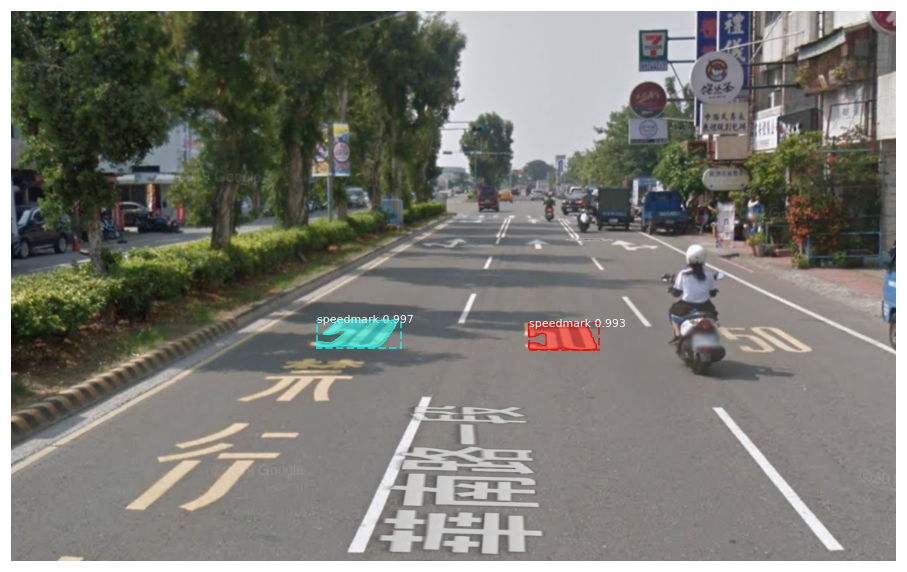

In [ ]:
# Test specific image 測試特定影像
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
# load photograph
img = load_img('/content/drive/MyDrive/MaskRCNN/val/G646.png') ##########匯入要test的影像
img = img_to_array(img)
# make prediction
results = model.detect([img], verbose=0)
# get dictionary for first prediction
r = results[0]
# show photo with bounding boxes, masks, class labels and scores
visualize.display_instances(img, r['rois'], r['masks'], r['class_ids'], class_names, r['scores'])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


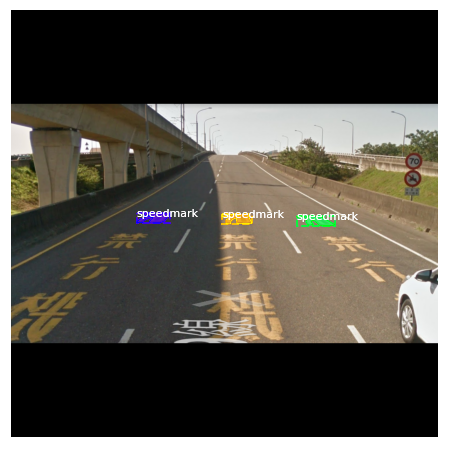

In [ ]:
# Test on a random image 測試隨機的影像
image_id = random.choice(dataset_val.image_ids)
# Load image and ground truth data
image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_val, config, image_id, use_mini_mask=False)

visualize.display_instances(image, gt_bbox, gt_mask, gt_class_id, 
                            dataset_train.class_names, figsize=(8, 8))

**Evaluation**

In [ ]:
##計算mAP
APs = []
np.random.shuffle(dataset_val.image_ids)
for image_id in dataset_val.image_ids: 
    # Load image and ground truth data
    image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset_val, config, image_id, use_mini_mask=False)
    molded_images = np.expand_dims(modellib.mold_image(image, config), 0)
    info = dataset_val.image_info[image_id]
    print("image ID: {}.{} ({}) {}".format(info["source"], info["id"], image_id, 
                                       dataset_val.image_reference(image_id)))
    # Run object detection
    result = model.detect([image], verbose=0)
    r = result[0]
    
    # Compute AP
    AP, precisions, recalls, overlaps =\
        utils.compute_ap(gt_bbox, gt_class_id, gt_mask, r["rois"], r["class_ids"], r["scores"], r['masks'], iou_threshold=0.5)
    APs.append(AP)

print("mAP: ", np.mean(APs))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


image ID: sign.F551.png (194) /content/MaskRCNN/val/F551.png
gt_match: [0. 1.]
pred_match: [ 0.  1. -1.]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


image ID: sign.E243.PNG (290) /content/MaskRCNN/val/E243.PNG
gt_match: [ 2.  0. -1. -1. -1.]
pred_match: [ 1. -1.  0.]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


image ID: sign.F629.png (147) /content/MaskRCNN/val/F629.png
gt_match: [1. 0.]
pred_match: [1. 0.]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


image ID: sign.E95.PNG (370) /content/MaskRCNN/val/E95.PNG
gt_match: [ 0. -1. -1. -1.]
pred_match: [0.]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


image ID: sign.E121.PNG (356) /content/MaskRCNN/val/E121.PNG
gt_match: [ 0.  1. -1.]
pred_match: [0. 1.]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


image ID: sign.G9.PNG (65) /content/MaskRCNN/val/G9.PNG
gt_match: [-1. -1. -1. -1. -1. -1.]
pred_match: [-1.]
image ID: sign.E304.PNG (263) /content/MaskRCNN/val/E304.PNG


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


gt_match: [0. 1.]
pred_match: [0. 1.]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


image ID: sign.32.JPG (449) /content/MaskRCNN/val/32.JPG
gt_match: [ 0.  2. -1. -1.  1.]
pred_match: [ 0.  4.  1. -1.]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


image ID: sign.9.jpg (472) /content/MaskRCNN/val/9.jpg
gt_match: [-1. -1. -1. -1. -1.  1. -1. -1.  0. -1.]
pred_match: [8. 5.]
image ID: sign.E324.PNG (254) /content/MaskRCNN/val/E324.PNG


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


gt_match: [1. 0.]
pred_match: [1. 0.]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


image ID: sign.G3.PNG (68) /content/MaskRCNN/val/G3.PNG
gt_match: [-1.  0.]
pred_match: [ 1. -1.]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


image ID: sign.E86.PNG (378) /content/MaskRCNN/val/E86.PNG
gt_match: [ 4.  0.  1. -1. -1.]
pred_match: [ 1.  2. -1. -1.  0.]
image ID: sign.E177.PNG (322) /content/MaskRCNN/val/E177.PNG


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


gt_match: [1. 0.]
pred_match: [1. 0.]
image ID: sign.E366.PNG (227) /content/MaskRCNN/val/E366.PNG


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


gt_match: [-1.  0.]
pred_match: [1.]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


image ID: sign.G131.png (12) /content/MaskRCNN/val/G131.png
gt_match: [-1. -1.  1.  0.]
pred_match: [3. 2.]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


image ID: sign.29.JPG (452) /content/MaskRCNN/val/29.JPG
gt_match: [-1. -1. -1.  0.  2. -1.  1.]
pred_match: [3. 6. 4.]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


image ID: sign.G587.png (112) /content/MaskRCNN/val/G587.png
gt_match: [-1. -1.]
pred_match: []
image ID: sign.E247.PNG (288) /content/MaskRCNN/val/E247.PNG


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


gt_match: [1. 0.]
pred_match: [1. 0.]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


image ID: sign.E11.PNG (437) /content/MaskRCNN/val/E11.PNG
gt_match: [-1. -1.  1.  0.  3. -1.]
pred_match: [ 3.  2. -1.  4.]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


image ID: sign.G175.png (1) /content/MaskRCNN/val/G175.png
gt_match: [-1.  0.]
pred_match: [1.]
image ID: sign.E364.PNG (229) /content/MaskRCNN/val/E364.PNG


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


gt_match: [0. 2.]
pred_match: [ 0. -1.  1.]
image ID: sign.E223.PNG (302) /content/MaskRCNN/val/E223.PNG


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


gt_match: [1. 0.]
pred_match: [1. 0.]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


image ID: sign.F593.png (166) /content/MaskRCNN/val/F593.png
gt_match: [0. 1.]
pred_match: [0. 1.]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


image ID: sign.28.JPG (453) /content/MaskRCNN/val/28.JPG
gt_match: [ 0.  1. -1. -1.]
pred_match: [0. 1.]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


image ID: sign.E206.PNG (309) /content/MaskRCNN/val/E206.PNG
gt_match: [-1. -1. -1.  0.  1.]
pred_match: [3. 4.]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


image ID: sign.E231.PNG (295) /content/MaskRCNN/val/E231.PNG
gt_match: [0. 1. 2.]
pred_match: [0. 1. 2.]
image ID: sign.E42.PNG (409) /content/MaskRCNN/val/E42.PNG


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


gt_match: [-1.  2.  1.]
pred_match: [-1.  2.  1. -1. -1. -1.]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


image ID: sign.G569.png (121) /content/MaskRCNN/val/G569.png
gt_match: [-1. -1.]
pred_match: [-1.]
image ID: sign.E147.PNG (346) /content/MaskRCNN/val/E147.PNG


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


gt_match: [-1. -1.  0. -1.]
pred_match: [ 2. -1.]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


image ID: sign.G575.png (117) /content/MaskRCNN/val/G575.png
gt_match: [-1.  0.]
pred_match: [1.]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


image ID: sign.E79.PNG (383) /content/MaskRCNN/val/E79.PNG
gt_match: [-1.  0. -1. -1.  2.  1.]
pred_match: [1. 5. 4.]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


image ID: sign.G625.png (87) /content/MaskRCNN/val/G625.png
gt_match: [1. 0.]
pred_match: [1. 0.]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


image ID: sign.G136.png (7) /content/MaskRCNN/val/G136.png
gt_match: [-1. -1.  0.  1.]
pred_match: [2. 3.]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


image ID: sign.26.JPG (455) /content/MaskRCNN/val/26.JPG
gt_match: [-1. -1.  0. -1. -1. -1.]
pred_match: [2.]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


image ID: sign.G552.png (130) /content/MaskRCNN/val/G552.png
gt_match: [0. 1.]
pred_match: [ 0.  1. -1.]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


image ID: sign.F616.png (155) /content/MaskRCNN/val/F616.png
gt_match: [ 1.  0. -1.]
pred_match: [1. 0.]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


image ID: sign.E32.PNG (417) /content/MaskRCNN/val/E32.PNG
gt_match: [-1.  2.  1. -1. -1.]
pred_match: [-1.  2.  1.]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


image ID: sign.G20.PNG (57) /content/MaskRCNN/val/G20.PNG
gt_match: [-1.  1.]
pred_match: [-1.  1. -1.]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


image ID: sign.E14.PNG (434) /content/MaskRCNN/val/E14.PNG
gt_match: [-1. -1.  1. -1. -1.  0. -1.]
pred_match: [5. 2.]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


image ID: sign.4.jpg (476) /content/MaskRCNN/val/4.jpg
gt_match: [-1. -1.  0. -1.]
pred_match: [2.]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


image ID: sign.G572.png (118) /content/MaskRCNN/val/G572.png
gt_match: [ 0. -1.]
pred_match: [0.]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


image ID: sign.E84.PNG (380) /content/MaskRCNN/val/E84.PNG
gt_match: [-1.  0.  1.]
pred_match: [1. 2.]
image ID: sign.E290.PNG (268) /content/MaskRCNN/val/E290.PNG


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


gt_match: [1. 0.]
pred_match: [1. 0.]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


image ID: sign.22.JPG (459) /content/MaskRCNN/val/22.JPG
gt_match: [-1. -1.]
pred_match: []
image ID: sign.E426.PNG (208) /content/MaskRCNN/val/E426.PNG


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


gt_match: [ 0. -1.]
pred_match: [0.]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


image ID: sign.G70.png (43) /content/MaskRCNN/val/G70.png
gt_match: [-1. -1.  1.  0.]
pred_match: [3. 2.]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


image ID: sign.F574.png (179) /content/MaskRCNN/val/F574.png
gt_match: [0. 1.]
pred_match: [ 0.  1. -1.]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


image ID: sign.E313.PNG (259) /content/MaskRCNN/val/E313.PNG
gt_match: [ 0. -1. -1.]
pred_match: [0.]
image ID: sign.E52.PNG (401) /content/MaskRCNN/val/E52.PNG


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


gt_match: [-1.  0.]
pred_match: [1.]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


image ID: sign.G110.png (25) /content/MaskRCNN/val/G110.png
gt_match: [-1. -1.  0.  1.]
pred_match: [2. 3.]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


image ID: sign.G606.png (98) /content/MaskRCNN/val/G606.png
gt_match: [2. 0. 4.]
pred_match: [ 1. -1.  0. -1.  2.]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


image ID: sign.F641.png (140) /content/MaskRCNN/val/F641.png
gt_match: [2. 1.]
pred_match: [-1.  1.  0.]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


image ID: sign.13.JPG (468) /content/MaskRCNN/val/13.JPG
gt_match: [ 0. -1. -1. -1. -1.]
pred_match: [0.]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


image ID: sign.E158.PNG (336) /content/MaskRCNN/val/E158.PNG
gt_match: [-1. -1.  2.  0.  1.]
pred_match: [3. 4. 2.]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


image ID: sign.E317.PNG (257) /content/MaskRCNN/val/E317.PNG
gt_match: [ 0. -1.]
pred_match: [0.]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


image ID: sign.30.JPG (451) /content/MaskRCNN/val/30.JPG
gt_match: [-1. -1. -1.]
pred_match: []


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


image ID: sign.25.JPG (456) /content/MaskRCNN/val/25.JPG
gt_match: [-1. -1.  0. -1. -1.]
pred_match: [2.]
image ID: sign.E51.PNG (402) /content/MaskRCNN/val/E51.PNG


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


gt_match: [-1.  1.  0.]
pred_match: [2. 1.]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


image ID: sign.G108.png (27) /content/MaskRCNN/val/G108.png
gt_match: [-1. -1.  0.  1.]
pred_match: [2. 3.]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


image ID: sign.E160.PNG (335) /content/MaskRCNN/val/E160.PNG
gt_match: [-1.  1.  2.  0.]
pred_match: [3. 1. 2.]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


image ID: sign.F559.png (188) /content/MaskRCNN/val/F559.png
gt_match: [0. 1.]
pred_match: [ 0.  1. -1.]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


image ID: sign.F563.png (184) /content/MaskRCNN/val/F563.png
gt_match: [0. 1.]
pred_match: [0. 1.]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


image ID: sign.G608.png (97) /content/MaskRCNN/val/G608.png
gt_match: [1. 0.]
pred_match: [1. 0.]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


image ID: sign.G559.png (126) /content/MaskRCNN/val/G559.png
gt_match: [1. 0.]
pred_match: [ 1.  0. -1.]
image ID: sign.E284.PNG (272) /content/MaskRCNN/val/E284.PNG


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


gt_match: [ 3. -1.  0.]
pred_match: [ 2. -1. -1.  0.]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


image ID: sign.G129.png (13) /content/MaskRCNN/val/G129.png
gt_match: [-1. -1.  1.  0.]
pred_match: [3. 2.]
image ID: sign.E175.PNG (323) /content/MaskRCNN/val/E175.PNG


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


gt_match: [-1.  0.]
pred_match: [1.]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


image ID: sign.E352.PNG (238) /content/MaskRCNN/val/E352.PNG
gt_match: [1. 0.]
pred_match: [1. 0.]
image ID: sign.E365.PNG (228) /content/MaskRCNN/val/E365.PNG


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


gt_match: [1. 0.]
pred_match: [1. 0.]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


image ID: sign.G98.png (34) /content/MaskRCNN/val/G98.png
gt_match: [-1. -1.  1.  0.]
pred_match: [3. 2.]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


image ID: sign.21.JPG (460) /content/MaskRCNN/val/21.JPG
gt_match: [2. 0.]
pred_match: [ 1. -1.  0.]
image ID: sign.E178.PNG (321) /content/MaskRCNN/val/E178.PNG


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


gt_match: [-1.  0.]
pred_match: [1.]
image ID: sign.E226.PNG (300) /content/MaskRCNN/val/E226.PNG


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


gt_match: [-1. -1.]
pred_match: [-1.]
image ID: sign.E380.PNG (219) /content/MaskRCNN/val/E380.PNG


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


gt_match: [1. 2. 0.]
pred_match: [2. 0. 1.]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


image ID: sign.G117.png (19) /content/MaskRCNN/val/G117.png
gt_match: [-1. -1.  0.  1.]
pred_match: [ 2.  3. -1.]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


image ID: sign.G113.png (23) /content/MaskRCNN/val/G113.png
gt_match: [-1. -1.  1.  0.]
pred_match: [3. 2.]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


image ID: sign.F592.png (167) /content/MaskRCNN/val/F592.png
gt_match: [1. 0.]
pred_match: [1. 0.]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


image ID: sign.G106.png (29) /content/MaskRCNN/val/G106.png
gt_match: [-1. -1.  0.  1.]
pred_match: [2. 3.]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


image ID: sign.F566.png (183) /content/MaskRCNN/val/F566.png
gt_match: [0. 1.]
pred_match: [0. 1.]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


image ID: sign.G638.png (78) /content/MaskRCNN/val/G638.png
gt_match: [0. 1.]
pred_match: [0. 1.]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


image ID: sign.G19.PNG (58) /content/MaskRCNN/val/G19.PNG
gt_match: [-1. -1.  0.  1.]
pred_match: [2. 3.]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


image ID: sign.G645.png (72) /content/MaskRCNN/val/G645.png
gt_match: [0. 1.]
pred_match: [0. 1.]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


image ID: sign.E377.PNG (220) /content/MaskRCNN/val/E377.PNG
gt_match: [-1. -1.  0.]
pred_match: [2.]
image ID: sign.E155.PNG (339) /content/MaskRCNN/val/E155.PNG


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


gt_match: [2. 0. 1.]
pred_match: [1. 2. 0.]
image ID: sign.E172.PNG (324) /content/MaskRCNN/val/E172.PNG


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


gt_match: [1. 0. 3.]
pred_match: [ 1.  0. -1.  2.]
image ID: sign.E419.PNG (209) /content/MaskRCNN/val/E419.PNG


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


gt_match: [ 0. -1. -1.]
pred_match: [0.]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


image ID: sign.G581.png (115) /content/MaskRCNN/val/G581.png
gt_match: [0. 1. 2.]
pred_match: [0. 1. 2.]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


image ID: sign.G626.png (86) /content/MaskRCNN/val/G626.png
gt_match: [1. 3.]
pred_match: [-1.  0. -1.  1. -1.]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


image ID: sign.E169.PNG (327) /content/MaskRCNN/val/E169.PNG
gt_match: [-1. -1.  1.  0. -1.]
pred_match: [3. 2.]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


image ID: sign.G611.png (95) /content/MaskRCNN/val/G611.png
gt_match: [1. 0.]
pred_match: [1. 0.]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


image ID: sign.E65.PNG (393) /content/MaskRCNN/val/E65.PNG
gt_match: [-1. -1. -1. -1.  0.]
pred_match: [ 4. -1.]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


image ID: sign.E456.PNG (198) /content/MaskRCNN/val/E456.PNG
gt_match: [-1. -1.]
pred_match: []


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


image ID: sign.E23.PNG (425) /content/MaskRCNN/val/E23.PNG
gt_match: [ 0.  2. -1.  1.]
pred_match: [0. 3. 1.]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


image ID: sign.G591.png (108) /content/MaskRCNN/val/G591.png
gt_match: [0. 1.]
pred_match: [0. 1.]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


image ID: sign.F634.png (144) /content/MaskRCNN/val/F634.png
gt_match: [0. 1.]
pred_match: [0. 1.]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


image ID: sign.G25.PNG (52) /content/MaskRCNN/val/G25.PNG
gt_match: [-1. -1.  1.  0.]
pred_match: [3. 2.]
image ID: sign.E70.PNG (389) /content/MaskRCNN/val/E70.PNG


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


gt_match: [-1.  0.]
pred_match: [1.]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


image ID: sign.F556.png (190) /content/MaskRCNN/val/F556.png
gt_match: [2. 0. 1.]
pred_match: [1. 2. 0.]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


image ID: sign.G583.png (114) /content/MaskRCNN/val/G583.png
gt_match: [-1. -1.]
pred_match: []
image ID: sign.E105.PNG (362) /content/MaskRCNN/val/E105.PNG


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


gt_match: [ 0. -1.]
pred_match: [0.]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


image ID: sign.G632.png (82) /content/MaskRCNN/val/G632.png
gt_match: [0. 1.]
pred_match: [0. 1.]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


image ID: sign.E150.PNG (344) /content/MaskRCNN/val/E150.PNG
gt_match: [-1.  0.  1.]
pred_match: [ 1.  2. -1.]
image ID: sign.E99.PNG (366) /content/MaskRCNN/val/E99.PNG


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


gt_match: [ 0.  1. -1. -1.]
pred_match: [0. 1.]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


image ID: sign.G641.png (76) /content/MaskRCNN/val/G641.png
gt_match: [1. 0.]
pred_match: [ 1.  0. -1.]
image ID: sign.E180.PNG (319) /content/MaskRCNN/val/E180.PNG


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


gt_match: [-1. -1.  0.]
pred_match: [ 2. -1. -1.]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


image ID: sign.17.JPG (464) /content/MaskRCNN/val/17.JPG
gt_match: [-1. -1. -1. -1. -1.]
pred_match: []


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


image ID: sign.F555.png (191) /content/MaskRCNN/val/F555.png
gt_match: [0. 1.]
pred_match: [0. 1.]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


image ID: sign.G78.png (41) /content/MaskRCNN/val/G78.png
gt_match: [-1. -1.  0.  1.]
pred_match: [ 2.  3. -1.]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


image ID: sign.E29.PNG (419) /content/MaskRCNN/val/E29.PNG
gt_match: [-1.  4.  3.  0.  2.  1.]
pred_match: [3. 5. 4. 2. 1.]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


image ID: sign.F581.png (172) /content/MaskRCNN/val/F581.png
gt_match: [0. 1. 2.]
pred_match: [ 0.  1.  2. -1.]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


image ID: sign.F630.png (146) /content/MaskRCNN/val/F630.png
gt_match: [0. 1.]
pred_match: [0. 1.]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


image ID: sign.F635.png (143) /content/MaskRCNN/val/F635.png
gt_match: [0. 1.]
pred_match: [0. 1.]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


image ID: sign.F646.png (137) /content/MaskRCNN/val/F646.png
gt_match: [1. 0.]
pred_match: [1. 0.]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


image ID: sign.G5.PNG (67) /content/MaskRCNN/val/G5.PNG
gt_match: [-1. -1.]
pred_match: [-1.]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


image ID: sign.G128.png (14) /content/MaskRCNN/val/G128.png
gt_match: [-1. -1. -1.  0.]
pred_match: [3.]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


image ID: sign.F648.png (135) /content/MaskRCNN/val/F648.png
gt_match: [0. 1.]
pred_match: [0. 1.]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


image ID: sign.G605.png (99) /content/MaskRCNN/val/G605.png
gt_match: [0. 1.]
pred_match: [0. 1.]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


image ID: sign.F580.png (173) /content/MaskRCNN/val/F580.png
gt_match: [0. 1.]
pred_match: [0. 1.]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


image ID: sign.G135.png (8) /content/MaskRCNN/val/G135.png
gt_match: [-1.  0.]
pred_match: [1.]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


image ID: sign.E31.PNG (418) /content/MaskRCNN/val/E31.PNG
gt_match: [-1.  1.  2.  0. -1. -1.]
pred_match: [3. 1. 2.]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


image ID: sign.G16.PNG (60) /content/MaskRCNN/val/G16.PNG
gt_match: [-1. -1.  1.  0.]
pred_match: [3. 2.]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


image ID: sign.E436.PNG (204) /content/MaskRCNN/val/E436.PNG
gt_match: [ 0. -1.]
pred_match: [0.]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


image ID: sign.F650.png (133) /content/MaskRCNN/val/F650.png
gt_match: [2. 1.]
pred_match: [-1.  1.  0.]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


image ID: sign.E27.PNG (421) /content/MaskRCNN/val/E27.PNG
gt_match: [-1. -1.  2.  0.]
pred_match: [ 3. -1.  2.]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


image ID: sign.F626.png (149) /content/MaskRCNN/val/F626.png
gt_match: [ 0. -1. -1.]
pred_match: [0.]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


image ID: sign.G80.png (39) /content/MaskRCNN/val/G80.png
gt_match: [-1. -1.  1.  0.]
pred_match: [ 3.  2. -1.]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


image ID: sign.E77.PNG (385) /content/MaskRCNN/val/E77.PNG
gt_match: [-1.  0. -1.]
pred_match: [ 1. -1.]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


image ID: sign.G11.PNG (64) /content/MaskRCNN/val/G11.PNG
gt_match: [-1. -1. -1.  1.  0.  2.]
pred_match: [4. 3. 5.]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


image ID: sign.E91.PNG (373) /content/MaskRCNN/val/E91.PNG
gt_match: [-1.  0.  1.]
pred_match: [1. 2.]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


image ID: sign.E439.PNG (203) /content/MaskRCNN/val/E439.PNG
gt_match: [0. 1.]
pred_match: [ 0.  1. -1. -1.]
image ID: sign.E254.PNG (286) /content/MaskRCNN/val/E254.PNG


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


gt_match: [ 0. -1.]
pred_match: [0.]
image ID: sign.E212.PNG (308) /content/MaskRCNN/val/E212.PNG


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


gt_match: [2. 0.]
pred_match: [ 1. -1.  0.]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


image ID: sign.14.JPG (467) /content/MaskRCNN/val/14.JPG
gt_match: [ 1.  2.  0. -1. -1.]
pred_match: [2. 0. 1.]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


image ID: sign.F615.png (156) /content/MaskRCNN/val/F615.png
gt_match: [ 0.  1. -1.]
pred_match: [0. 1.]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


image ID: sign.G24.PNG (53) /content/MaskRCNN/val/G24.PNG
gt_match: [-1.  0.]
pred_match: [1.]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


image ID: sign.E215.PNG (306) /content/MaskRCNN/val/E215.PNG
gt_match: [1. 2. 0.]
pred_match: [ 2.  0.  1. -1. -1.]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


image ID: sign.E46.PNG (405) /content/MaskRCNN/val/E46.PNG
gt_match: [2. 1. 0.]
pred_match: [2. 1. 0.]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


image ID: sign.E26.PNG (422) /content/MaskRCNN/val/E26.PNG
gt_match: [-1. -1. -1. -1.]
pred_match: []
image ID: sign.E270.PNG (284) /content/MaskRCNN/val/E270.PNG


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


gt_match: [1. 0.]
pred_match: [1. 0.]
image ID: sign.E331.PNG (250) /content/MaskRCNN/val/E331.PNG


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


gt_match: [-1.  0.]
pred_match: [1.]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


image ID: sign.G594.png (106) /content/MaskRCNN/val/G594.png
gt_match: [ 0. -1.]
pred_match: [0.]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


image ID: sign.E96.PNG (369) /content/MaskRCNN/val/E96.PNG
gt_match: [-1.  0.  1. -1. -1.]
pred_match: [1. 2.]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


image ID: sign.G109.png (26) /content/MaskRCNN/val/G109.png
gt_match: [-1. -1.  0.  1.]
pred_match: [2. 3.]
image ID: sign.E57.PNG (396) /content/MaskRCNN/val/E57.PNG


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


gt_match: [-1.  0.]
pred_match: [1.]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


image ID: sign.E184.PNG (315) /content/MaskRCNN/val/E184.PNG
gt_match: [-1.  1.  0.]
pred_match: [2. 1.]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


image ID: sign.G119.png (17) /content/MaskRCNN/val/G119.png
gt_match: [-1. -1.  1.  0.]
pred_match: [3. 2.]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


image ID: sign.E214.PNG (307) /content/MaskRCNN/val/E214.PNG
gt_match: [ 4. -1.  0.  3.  2.  1.]
pred_match: [2. 5. 4. 3. 0.]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


image ID: sign.E452.PNG (199) /content/MaskRCNN/val/E452.PNG
gt_match: [1. 0.]
pred_match: [1. 0.]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


image ID: sign.G612.png (94) /content/MaskRCNN/val/G612.png
gt_match: [1. 0.]
pred_match: [1. 0.]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


image ID: sign.E17.PNG (431) /content/MaskRCNN/val/E17.PNG
gt_match: [ 1.  0.  2. -1. -1.]
pred_match: [ 1.  0.  2. -1.]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


image ID: sign.E53.PNG (400) /content/MaskRCNN/val/E53.PNG
gt_match: [ 2.  0. -1.  1.]
pred_match: [1. 3. 0.]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


image ID: sign.G592.png (107) /content/MaskRCNN/val/G592.png
gt_match: [-1. -1.]
pred_match: [-1.]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


image ID: sign.F558.png (189) /content/MaskRCNN/val/F558.png
gt_match: [0. 1.]
pred_match: [0. 1.]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


image ID: sign.G590.png (109) /content/MaskRCNN/val/G590.png
gt_match: [ 0. -1.]
pred_match: [0.]
image ID: sign.E56.PNG (397) /content/MaskRCNN/val/E56.PNG


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


gt_match: [-1. -1.]
pred_match: [-1.]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


image ID: sign.F644.png (138) /content/MaskRCNN/val/F644.png
gt_match: [0. 1.]
pred_match: [0. 1.]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


image ID: sign.E354.PNG (236) /content/MaskRCNN/val/E354.PNG
gt_match: [1. 0.]
pred_match: [1. 0.]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


image ID: sign.E75.PNG (387) /content/MaskRCNN/val/E75.PNG
gt_match: [ 0.  1. -1.]
pred_match: [0. 1.]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


image ID: sign.E145.PNG (348) /content/MaskRCNN/val/E145.PNG
gt_match: [-1. -1.  1.  0.]
pred_match: [3. 2.]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


image ID: sign.E90.PNG (374) /content/MaskRCNN/val/E90.PNG
gt_match: [ 1.  0.  2. -1. -1.]
pred_match: [1. 0. 2.]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


image ID: sign.G14.PNG (62) /content/MaskRCNN/val/G14.PNG
gt_match: [-1. -1.  2.  1.]
pred_match: [-1.  3.  2.]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


image ID: sign.G79.png (40) /content/MaskRCNN/val/G79.png
gt_match: [-1. -1.  1.  0.]
pred_match: [ 3.  2. -1.]
image ID: sign.E289.PNG (269) /content/MaskRCNN/val/E289.PNG


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


gt_match: [-1.  0.]
pred_match: [1.]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


image ID: sign.E111.PNG (360) /content/MaskRCNN/val/E111.PNG
gt_match: [0. 1.]
pred_match: [0. 1.]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


image ID: sign.24.JPG (457) /content/MaskRCNN/val/24.JPG
gt_match: [ 2. -1.  0.  1.]
pred_match: [2. 3. 0.]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


image ID: sign.E236.PNG (292) /content/MaskRCNN/val/E236.PNG
gt_match: [1. 2. 0.]
pred_match: [2. 0. 1.]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


image ID: sign.E349.PNG (240) /content/MaskRCNN/val/E349.PNG
gt_match: [2. 1. 0.]
pred_match: [2. 1. 0.]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


image ID: sign.E125.PNG (354) /content/MaskRCNN/val/E125.PNG
gt_match: [ 1.  0. -1.]
pred_match: [1. 0.]
image ID: sign.E69.PNG (390) /content/MaskRCNN/val/E69.PNG


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


gt_match: [-1. -1.]
pred_match: []
image ID: sign.E153.PNG (341) /content/MaskRCNN/val/E153.PNG


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


gt_match: [1. 0.]
pred_match: [1. 0.]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


image ID: sign.27.JPG (454) /content/MaskRCNN/val/27.JPG
gt_match: [-1. -1. -1. -1. -1.]
pred_match: []
image ID: sign.E20.PNG (428) /content/MaskRCNN/val/E20.PNG


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


gt_match: [1. 0.]
pred_match: [1. 0.]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


image ID: sign.G595.png (105) /content/MaskRCNN/val/G595.png
gt_match: [0. 2.]
pred_match: [ 0. -1.  1.]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


image ID: sign.F614.png (157) /content/MaskRCNN/val/F614.png
gt_match: [0. 1.]
pred_match: [0. 1.]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


image ID: sign.G623.png (89) /content/MaskRCNN/val/G623.png
gt_match: [-1.  0.]
pred_match: [1.]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


image ID: sign.E171.PNG (325) /content/MaskRCNN/val/E171.PNG
gt_match: [-1. -1.  1.  0.]
pred_match: [3. 2.]
image ID: sign.E228.PNG (298) /content/MaskRCNN/val/E228.PNG


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


gt_match: [ 0. -1.]
pred_match: [0.]
image ID: sign.E285.PNG (271) /content/MaskRCNN/val/E285.PNG


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


gt_match: [-1.  0.]
pred_match: [1.]
image ID: sign.E63.PNG (394) /content/MaskRCNN/val/E63.PNG


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


gt_match: [-1. -1.]
pred_match: []


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


image ID: sign.E168.PNG (328) /content/MaskRCNN/val/E168.PNG
gt_match: [-1. -1.  1.  0.]
pred_match: [3. 2.]
image ID: sign.E62.PNG (395) /content/MaskRCNN/val/E62.PNG


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


gt_match: [ 0. -1.]
pred_match: [0.]
image ID: sign.E373.PNG (222) /content/MaskRCNN/val/E373.PNG


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


gt_match: [1. 0.]
pred_match: [1. 0.]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


image ID: sign.F591.png (168) /content/MaskRCNN/val/F591.png
gt_match: [0. 1.]
pred_match: [0. 1.]
image ID: sign.E297.PNG (264) /content/MaskRCNN/val/E297.PNG


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


gt_match: [-1.  0.]
pred_match: [1.]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


image ID: sign.E337.PNG (247) /content/MaskRCNN/val/E337.PNG
gt_match: [ 4. -1.  1.  0.  2.]
pred_match: [ 3.  2.  4. -1.  0.]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


image ID: sign.F619.png (154) /content/MaskRCNN/val/F619.png
gt_match: [1. 0.]
pred_match: [1. 0.]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


image ID: sign.G647.png (70) /content/MaskRCNN/val/G647.png
gt_match: [ 0. -1.]
pred_match: [0.]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


image ID: sign.F599.png (163) /content/MaskRCNN/val/F599.png
gt_match: [ 0. -1.]
pred_match: [0.]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


image ID: sign.G127.png (15) /content/MaskRCNN/val/G127.png
gt_match: [-1. -1.  1.  0.]
pred_match: [3. 2.]
image ID: sign.E225.PNG (301) /content/MaskRCNN/val/E225.PNG


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


gt_match: [ 0. -1. -1.]
pred_match: [0.]
image ID: sign.E394.PNG (217) /content/MaskRCNN/val/E394.PNG


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


gt_match: [-1.  0.]
pred_match: [1.]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


image ID: sign.F552.png (193) /content/MaskRCNN/val/F552.png
gt_match: [0. 1.]
pred_match: [0. 1.]
image ID: sign.E44.PNG (407) /content/MaskRCNN/val/E44.PNG


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


gt_match: [0. 1.]
pred_match: [0. 1.]
image ID: sign.E406.PNG (214) /content/MaskRCNN/val/E406.PNG


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


gt_match: [ 0. -1.]
pred_match: [ 0. -1.]
image ID: sign.E336.PNG (248) /content/MaskRCNN/val/E336.PNG


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


gt_match: [-1.  0.]
pred_match: [ 1. -1.]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


image ID: sign.E195.PNG (313) /content/MaskRCNN/val/E195.PNG
gt_match: [-1. -1.  0.  1.]
pred_match: [2. 3.]
image ID: sign.E342.PNG (244) /content/MaskRCNN/val/E342.PNG


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


gt_match: [ 0. -1.]
pred_match: [ 0. -1.]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


image ID: sign.E18.PNG (430) /content/MaskRCNN/val/E18.PNG
gt_match: [-1. -1. -1.  2.  0. -1.  1.]
pred_match: [ 4.  6.  3. -1.]
image ID: sign.E277.PNG (279) /content/MaskRCNN/val/E277.PNG


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


gt_match: [1. 0.]
pred_match: [1. 0.]
image ID: sign.E361.PNG (232) /content/MaskRCNN/val/E361.PNG


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


gt_match: [-1. -1. -1.  1.  0.]
pred_match: [4. 3.]
image ID: sign.E375.PNG (221) /content/MaskRCNN/val/E375.PNG


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


gt_match: [-1. -1.]
pred_match: [-1.]
image ID: sign.E49.PNG (403) /content/MaskRCNN/val/E49.PNG


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


gt_match: [ 0. -1.]
pred_match: [0.]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


image ID: sign.E235.PNG (293) /content/MaskRCNN/val/E235.PNG
gt_match: [2. 0. 1.]
pred_match: [1. 2. 0.]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


image ID: sign.G83.png (37) /content/MaskRCNN/val/G83.png
gt_match: [-1. -1. -1. -1.  0.  2.]
pred_match: [ 4. -1.  5.]
image ID: sign.E102.PNG (364) /content/MaskRCNN/val/E102.PNG


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


gt_match: [ 0. -1.]
pred_match: [0.]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


image ID: sign.20.JPG (461) /content/MaskRCNN/val/20.JPG
gt_match: [-1. -1. -1. -1. -1. -1. -1. -1. -1.]
pred_match: [-1.]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


image ID: sign.E34.PNG (415) /content/MaskRCNN/val/E34.PNG
gt_match: [-1. -1.  0.  2.]
pred_match: [ 2. -1.  3.]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


image ID: sign.G624.png (88) /content/MaskRCNN/val/G624.png
gt_match: [0. 1.]
pred_match: [0. 1.]
image ID: sign.E240.PNG (291) /content/MaskRCNN/val/E240.PNG


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


gt_match: [1. 0.]
pred_match: [1. 0.]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


image ID: sign.G551.png (131) /content/MaskRCNN/val/G551.png
gt_match: [0. 1.]
pred_match: [0. 1.]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


image ID: sign.E163.PNG (332) /content/MaskRCNN/val/E163.PNG
gt_match: [ 2. -1.  1.  0.]
pred_match: [3. 2. 0.]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


image ID: sign.E5.PNG (442) /content/MaskRCNN/val/E5.PNG
gt_match: [-1.  1.  0. -1.]
pred_match: [2. 1.]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


image ID: sign.F550.png (195) /content/MaskRCNN/val/F550.png
gt_match: [0. 1.]
pred_match: [0. 1.]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


image ID: sign.E12.PNG (436) /content/MaskRCNN/val/E12.PNG
gt_match: [ 0.  1. -1. -1.]
pred_match: [0. 1.]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


image ID: sign.G560.png (125) /content/MaskRCNN/val/G560.png
gt_match: [ 0. -1.]
pred_match: [0.]
image ID: sign.E47.PNG (404) /content/MaskRCNN/val/E47.PNG


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


gt_match: [0. 1.]
pred_match: [0. 1.]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


image ID: sign.F576.png (177) /content/MaskRCNN/val/F576.png
gt_match: [1. 0.]
pred_match: [1. 0.]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


image ID: sign.G59.png (47) /content/MaskRCNN/val/G59.png
gt_match: [-1. -1. -1.  2.  0.  1.]
pred_match: [ 4.  5.  3. -1.]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


image ID: sign.E152.PNG (342) /content/MaskRCNN/val/E152.PNG
gt_match: [-1. -1.  1.]
pred_match: [-1.  2. -1.]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


image ID: sign.E76.PNG (386) /content/MaskRCNN/val/E76.PNG
gt_match: [-1. -1.  0.]
pred_match: [2.]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


image ID: sign.E74.PNG (388) /content/MaskRCNN/val/E74.PNG
gt_match: [ 0. -1. -1. -1.]
pred_match: [0.]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


image ID: sign.G118.png (18) /content/MaskRCNN/val/G118.png
gt_match: [-1. -1.  1.  0.]
pred_match: [3. 2.]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


image ID: sign.F554.png (192) /content/MaskRCNN/val/F554.png
gt_match: [0. 1.]
pred_match: [0. 1.]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


image ID: sign.G634.png (81) /content/MaskRCNN/val/G634.png
gt_match: [1. 0.]
pred_match: [1. 0.]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


image ID: sign.G603.png (100) /content/MaskRCNN/val/G603.png
gt_match: [0. 1.]
pred_match: [0. 1.]
image ID: sign.E271.PNG (283) /content/MaskRCNN/val/E271.PNG


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


gt_match: [ 0. -1. -1.]
pred_match: [0.]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


image ID: sign.E353.PNG (237) /content/MaskRCNN/val/E353.PNG
gt_match: [1. 0.]
pred_match: [ 1.  0. -1.]
image ID: sign.E360.PNG (233) /content/MaskRCNN/val/E360.PNG


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


gt_match: [-1. -1. -1.  0.]
pred_match: [ 3. -1.]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


image ID: sign.E38.PNG (412) /content/MaskRCNN/val/E38.PNG
gt_match: [-1. -1. -1.]
pred_match: [-1.]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


image ID: sign.E222.PNG (303) /content/MaskRCNN/val/E222.PNG
gt_match: [-1. -1.  2.  0.  1.]
pred_match: [ 3.  4.  2. -1. -1.]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


image ID: sign.34.JPG (447) /content/MaskRCNN/val/34.JPG
gt_match: [ 0. -1.]
pred_match: [0.]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


image ID: sign.E78.PNG (384) /content/MaskRCNN/val/E78.PNG
gt_match: [0. 1. 3.]
pred_match: [ 0.  1. -1.  2.]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


image ID: sign.G556.png (127) /content/MaskRCNN/val/G556.png
gt_match: [0. 1.]
pred_match: [0. 1.]
image ID: sign.E230.PNG (296) /content/MaskRCNN/val/E230.PNG


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


gt_match: [1. 0.]
pred_match: [1. 0.]
image ID: sign.5.jpg (475) /content/MaskRCNN/val/5.jpg


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


gt_match: [-1. -1.]
pred_match: []


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


image ID: sign.G23.PNG (54) /content/MaskRCNN/val/G23.PNG
gt_match: [-1. -1.  0.  3.]
pred_match: [ 2. -1. -1.  3.]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


image ID: sign.E229.PNG (297) /content/MaskRCNN/val/E229.PNG
gt_match: [-1.  0.]
pred_match: [1.]
image ID: sign.E37.PNG (413) /content/MaskRCNN/val/E37.PNG


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


gt_match: [ 0. -1.]
pred_match: [0.]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


image ID: sign.F569.png (180) /content/MaskRCNN/val/F569.png
gt_match: [0. 1.]
pred_match: [0. 1.]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


image ID: sign.F647.png (136) /content/MaskRCNN/val/F647.png
gt_match: [1. 0.]
pred_match: [1. 0.]
image ID: sign.E399.PNG (215) /content/MaskRCNN/val/E399.PNG


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


gt_match: [ 0. -1.]
pred_match: [0.]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


image ID: sign.G596.png (104) /content/MaskRCNN/val/G596.png
gt_match: [ 0. -1.]
pred_match: [0.]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


image ID: sign.E146.PNG (347) /content/MaskRCNN/val/E146.PNG
gt_match: [-1. -1.  0.  1.]
pred_match: [2. 3.]
image ID: sign.E118.PNG (358) /content/MaskRCNN/val/E118.PNG


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


gt_match: [2. 0.]
pred_match: [ 1. -1.  0.]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


image ID: sign.E10.PNG (438) /content/MaskRCNN/val/E10.PNG
gt_match: [-1. -1.  0.  1. -1.]
pred_match: [2. 3.]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


image ID: sign.G134.png (9) /content/MaskRCNN/val/G134.png
gt_match: [-1. -1.  1.  0.]
pred_match: [3. 2.]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


image ID: sign.G140.png (5) /content/MaskRCNN/val/G140.png
gt_match: [-1. -1.  0.  1.]
pred_match: [2. 3.]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


image ID: sign.G571.png (119) /content/MaskRCNN/val/G571.png
gt_match: [1. 0.]
pred_match: [1. 0.]
image ID: sign.E108.PNG (361) /content/MaskRCNN/val/E108.PNG


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


gt_match: [1. 0.]
pred_match: [1. 0.]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


image ID: sign.F560.png (187) /content/MaskRCNN/val/F560.png
gt_match: [0. 1.]
pred_match: [0. 1.]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


image ID: sign.F621.png (152) /content/MaskRCNN/val/F621.png
gt_match: [0. 1.]
pred_match: [0. 1.]
image ID: sign.E308.PNG (262) /content/MaskRCNN/val/E308.PNG


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


gt_match: [0. 1.]
pred_match: [0. 1.]
image ID: sign.E126.PNG (353) /content/MaskRCNN/val/E126.PNG


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


gt_match: [1. 0.]
pred_match: [1. 0.]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


image ID: sign.E310.PNG (261) /content/MaskRCNN/val/E310.PNG
gt_match: [ 4.  5.  0.  1. -1.  3.  2. -1. -1.]
pred_match: [ 2.  3.  6.  5.  0.  1. -1. -1.]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


image ID: sign.E98.PNG (367) /content/MaskRCNN/val/E98.PNG
gt_match: [-1.  0.]
pred_match: [ 1. -1.]
image ID: sign.E292.PNG (266) /content/MaskRCNN/val/E292.PNG


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


gt_match: [-1. -1.]
pred_match: []


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


image ID: sign.G599.png (102) /content/MaskRCNN/val/G599.png
gt_match: [0. 1.]
pred_match: [0. 1.]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


image ID: sign.G81.png (38) /content/MaskRCNN/val/G81.png
gt_match: [-1. -1.  0.  1.]
pred_match: [2. 3.]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


image ID: sign.G601.png (101) /content/MaskRCNN/val/G601.png
gt_match: [0. 1.]
pred_match: [0. 1.]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


image ID: sign.E161.PNG (334) /content/MaskRCNN/val/E161.PNG
gt_match: [-1. -1.  0.  1.]
pred_match: [2. 3.]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


image ID: sign.E43.PNG (408) /content/MaskRCNN/val/E43.PNG
gt_match: [-1. -1.  1.  0.]
pred_match: [ 3.  2. -1.]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


image ID: sign.G588.png (111) /content/MaskRCNN/val/G588.png
gt_match: [-1.  0.]
pred_match: [ 1. -1.]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


image ID: sign.G650.png (69) /content/MaskRCNN/val/G650.png
gt_match: [0. 2.]
pred_match: [ 0. -1.  1.]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


image ID: sign.E24.PNG (424) /content/MaskRCNN/val/E24.PNG
gt_match: [ 1. -1. -1.  0.]
pred_match: [3. 0.]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


image ID: sign.F562.png (185) /content/MaskRCNN/val/F562.png
gt_match: [0. 1.]
pred_match: [0. 1.]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


image ID: sign.E234.PNG (294) /content/MaskRCNN/val/E234.PNG
gt_match: [1. 0.]
pred_match: [1. 0.]
image ID: sign.E166.PNG (329) /content/MaskRCNN/val/E166.PNG


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


gt_match: [0. 1.]
pred_match: [0. 1.]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


image ID: sign.G105.png (30) /content/MaskRCNN/val/G105.png
gt_match: [-1. -1.  0.  1.]
pred_match: [2. 3.]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


image ID: sign.G27.PNG (50) /content/MaskRCNN/val/G27.PNG
gt_match: [-1. -1.  1.  0.]
pred_match: [ 3.  2. -1.]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


image ID: sign.G566.png (123) /content/MaskRCNN/val/G566.png
gt_match: [-1. -1.]
pred_match: []


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


image ID: sign.E25.PNG (423) /content/MaskRCNN/val/E25.PNG
gt_match: [-1. -1.  1.  0.  2.]
pred_match: [3. 2. 4.]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


image ID: sign.F601.png (162) /content/MaskRCNN/val/F601.png
gt_match: [1. 3.]
pred_match: [-1.  0. -1.  1.]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


image ID: sign.F627.png (148) /content/MaskRCNN/val/F627.png
gt_match: [0. 1.]
pred_match: [0. 1.]
image ID: sign.E283.PNG (273) /content/MaskRCNN/val/E283.PNG


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


gt_match: [-1.  0.]
pred_match: [1.]
image ID: sign.E280.PNG (276) /content/MaskRCNN/val/E280.PNG


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


gt_match: [2. 0.]
pred_match: [ 1. -1.  0.]
image ID: sign.E291.PNG (267) /content/MaskRCNN/val/E291.PNG


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


gt_match: [-1.  0.]
pred_match: [1.]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


image ID: sign.E316.PNG (258) /content/MaskRCNN/val/E316.PNG
gt_match: [0. 1.]
pred_match: [0. 1.]
image ID: sign.E13.PNG (435) /content/MaskRCNN/val/E13.PNG


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


gt_match: [1. 0.]
pred_match: [1. 0.]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


image ID: sign.F622.png (151) /content/MaskRCNN/val/F622.png
gt_match: [1. 0.]
pred_match: [1. 0.]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


image ID: sign.12.JPG (469) /content/MaskRCNN/val/12.JPG
gt_match: [-1. -1. -1. -1. -1. -1. -1. -1. -1.]
pred_match: []


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


image ID: sign.19.JPG (462) /content/MaskRCNN/val/19.JPG
gt_match: [-1. -1. -1. -1. -1.]
pred_match: []
image ID: sign.E149.PNG (345) /content/MaskRCNN/val/E149.PNG


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


gt_match: [-1. -1. -1. -1.]
pred_match: []
image ID: sign.16.JPG (465) /content/MaskRCNN/val/16.JPG


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


gt_match: [-1. -1.]
pred_match: []


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


image ID: sign.G21.PNG (56) /content/MaskRCNN/val/G21.PNG
gt_match: [-1.  1.]
pred_match: [-1.  1.]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


image ID: sign.F597.png (165) /content/MaskRCNN/val/F597.png
gt_match: [1. 0.]
pred_match: [1. 0.]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


image ID: sign.E323.PNG (255) /content/MaskRCNN/val/E323.PNG
gt_match: [ 1. -1. -1.]
pred_match: [-1.  0.]
image ID: sign.E255.PNG (285) /content/MaskRCNN/val/E255.PNG


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


gt_match: [ 0. -1. -1.]
pred_match: [0.]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


image ID: sign.E154.PNG (340) /content/MaskRCNN/val/E154.PNG
gt_match: [-1. -1. -1.  2.  1.  0.]
pred_match: [5. 4. 3.]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


image ID: sign.F649.png (134) /content/MaskRCNN/val/F649.png
gt_match: [0. 1.]
pred_match: [0. 1.]
image ID: sign.E104.PNG (363) /content/MaskRCNN/val/E104.PNG


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


gt_match: [-1. -1.]
pred_match: []


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


image ID: sign.G86.png (36) /content/MaskRCNN/val/G86.png
gt_match: [-1. -1. -1.  0.]
pred_match: [3.]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


image ID: sign.E181.PNG (318) /content/MaskRCNN/val/E181.PNG
gt_match: [ 0. -1. -1.]
pred_match: [0.]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


image ID: sign.18.JPG (463) /content/MaskRCNN/val/18.JPG
gt_match: [ 1. -1. -1.]
pred_match: [-1.  0.]
image ID: sign.8.jpg (473) /content/MaskRCNN/val/8.jpg


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


gt_match: [-1. -1.  1.  0.]
pred_match: [ 3.  2. -1.]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


image ID: sign.G132.png (11) /content/MaskRCNN/val/G132.png
gt_match: [-1. -1.  0.  1.]
pred_match: [2. 3.]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


image ID: sign.7.jpg (474) /content/MaskRCNN/val/7.jpg
gt_match: [-1. -1.  0.  1.]
pred_match: [2. 3.]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


image ID: sign.E45.PNG (406) /content/MaskRCNN/val/E45.PNG
gt_match: [ 1.  0. -1. -1. -1.]
pred_match: [1. 0.]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


image ID: sign.G29.PNG (48) /content/MaskRCNN/val/G29.PNG
gt_match: [-1.  1.]
pred_match: [-1.  1.]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


image ID: sign.F598.png (164) /content/MaskRCNN/val/F598.png
gt_match: [0. 1.]
pred_match: [ 0.  1. -1.]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


image ID: sign.G589.png (110) /content/MaskRCNN/val/G589.png
gt_match: [0. 1.]
pred_match: [0. 1.]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


image ID: sign.E93.PNG (371) /content/MaskRCNN/val/E93.PNG
gt_match: [ 3.  0.  1. -1. -1.]
pred_match: [ 1.  2. -1.  0.]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


image ID: sign.G555.png (128) /content/MaskRCNN/val/G555.png
gt_match: [0. 1.]
pred_match: [0. 1.]
image ID: sign.E85.PNG (379) /content/MaskRCNN/val/E85.PNG


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


gt_match: [2. 0. 1.]
pred_match: [1. 2. 0.]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


image ID: sign.G137.png (6) /content/MaskRCNN/val/G137.png
gt_match: [-1. -1.  0.  1.]
pred_match: [2. 3.]
image ID: sign.E281.PNG (275) /content/MaskRCNN/val/E281.PNG


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


gt_match: [-1.  0.]
pred_match: [ 1. -1.]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


image ID: sign.F589.png (170) /content/MaskRCNN/val/F589.png
gt_match: [0. 1.]
pred_match: [0. 1.]
image ID: sign.E428.PNG (207) /content/MaskRCNN/val/E428.PNG


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


gt_match: [-1.  0.]
pred_match: [1.]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


image ID: sign.F568.png (181) /content/MaskRCNN/val/F568.png
gt_match: [0. 1.]
pred_match: [0. 1.]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


image ID: sign.G13.PNG (63) /content/MaskRCNN/val/G13.PNG
gt_match: [-1.  0.]
pred_match: [ 1. -1.]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


image ID: sign.F587.png (171) /content/MaskRCNN/val/F587.png
gt_match: [0. 1.]
pred_match: [0. 1.]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


image ID: sign.F642.png (139) /content/MaskRCNN/val/F642.png
gt_match: [0. 1.]
pred_match: [0. 1.]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


image ID: sign.G60.png (46) /content/MaskRCNN/val/G60.png
gt_match: [-1. -1. -1.  1.  0. -1.]
pred_match: [4. 3.]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


image ID: sign.E275.PNG (280) /content/MaskRCNN/val/E275.PNG
gt_match: [ 1.  0. -1.]
pred_match: [1. 0.]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


image ID: sign.E39.PNG (411) /content/MaskRCNN/val/E39.PNG
gt_match: [-1. -1. -1. -1.]
pred_match: []


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


image ID: sign.F578.png (175) /content/MaskRCNN/val/F578.png
gt_match: [1. 0.]
pred_match: [ 1.  0. -1.]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


image ID: sign.F567.png (182) /content/MaskRCNN/val/F567.png
gt_match: [0. 1.]
pred_match: [0. 1.]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


image ID: sign.E227.PNG (299) /content/MaskRCNN/val/E227.PNG
gt_match: [1. 0.]
pred_match: [1. 0.]
image ID: sign.E442.PNG (200) /content/MaskRCNN/val/E442.PNG


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


gt_match: [1. 0.]
pred_match: [1. 0.]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


image ID: sign.G615.png (92) /content/MaskRCNN/val/G615.png
gt_match: [ 0. -1.]
pred_match: [0.]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


image ID: sign.E278.PNG (278) /content/MaskRCNN/val/E278.PNG
gt_match: [-1.  1.  0.]
pred_match: [2. 1.]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


image ID: sign.E6.PNG (441) /content/MaskRCNN/val/E6.PNG
gt_match: [ 1.  0. -1.]
pred_match: [1. 0.]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


image ID: sign.F604.png (161) /content/MaskRCNN/val/F604.png
gt_match: [0. 1.]
pred_match: [0. 1.]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


image ID: sign.E9.PNG (439) /content/MaskRCNN/val/E9.PNG
gt_match: [0. 1. 2.]
pred_match: [0. 1. 2.]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


image ID: sign.E87.PNG (377) /content/MaskRCNN/val/E87.PNG
gt_match: [ 2.  1.  0. -1. -1. -1.]
pred_match: [2. 1. 0.]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


image ID: sign.E117.PNG (359) /content/MaskRCNN/val/E117.PNG
gt_match: [-1. -1. -1.]
pred_match: [-1. -1. -1.]
image ID: sign.E272.PNG (282) /content/MaskRCNN/val/E272.PNG


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


gt_match: [0. 1.]
pred_match: [0. 1.]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


image ID: sign.E142.PNG (351) /content/MaskRCNN/val/E142.PNG
gt_match: [-1. -1. -1.  1.  0.]
pred_match: [4. 3.]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


image ID: sign.G550.png (132) /content/MaskRCNN/val/G550.png
gt_match: [1. 0.]
pred_match: [1. 0.]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


image ID: sign.E68.PNG (391) /content/MaskRCNN/val/E68.PNG
gt_match: [ 0. -1.]
pred_match: [0.]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


image ID: sign.G622.png (90) /content/MaskRCNN/val/G622.png
gt_match: [-1.  0.]
pred_match: [1.]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


image ID: sign.E165.PNG (330) /content/MaskRCNN/val/E165.PNG
gt_match: [-1.  1.  0.  2. -1.]
pred_match: [2. 1. 3.]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


image ID: sign.F577.png (176) /content/MaskRCNN/val/F577.png
gt_match: [0. 1.]
pred_match: [0. 1.]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


image ID: sign.G636.png (80) /content/MaskRCNN/val/G636.png
gt_match: [0. 1.]
pred_match: [0. 1.]
image ID: sign.E347.PNG (241) /content/MaskRCNN/val/E347.PNG


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


gt_match: [-1.  0.]
pred_match: [1.]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


image ID: sign.E97.PNG (368) /content/MaskRCNN/val/E97.PNG
gt_match: [ 0. -1. -1.]
pred_match: [ 0. -1.]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


image ID: sign.E100.PNG (365) /content/MaskRCNN/val/E100.PNG
gt_match: [-1. -1.  1. -1.  0.]
pred_match: [4. 2.]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


image ID: sign.E170.PNG (326) /content/MaskRCNN/val/E170.PNG
gt_match: [-1. -1.  0.]
pred_match: [ 2. -1.]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


image ID: sign.F605.png (160) /content/MaskRCNN/val/F605.png
gt_match: [0. 1.]
pred_match: [0. 1.]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


image ID: sign.E143.PNG (350) /content/MaskRCNN/val/E143.PNG
gt_match: [0. 1.]
pred_match: [0. 1.]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


image ID: sign.E54.PNG (399) /content/MaskRCNN/val/E54.PNG
gt_match: [-1. -1.  0. -1.]
pred_match: [2.]
image ID: sign.E201.PNG (310) /content/MaskRCNN/val/E201.PNG


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


gt_match: [1. 0.]
pred_match: [1. 0.]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


image ID: sign.G15.PNG (61) /content/MaskRCNN/val/G15.PNG
gt_match: [-1.  1.]
pred_match: [-1.  1. -1.]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


image ID: sign.G103.png (32) /content/MaskRCNN/val/G103.png
gt_match: [-1.  0.]
pred_match: [1.]
image ID: sign.E200.PNG (311) /content/MaskRCNN/val/E200.PNG


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


gt_match: [-1. -1.  0.]
pred_match: [2.]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


image ID: sign.F590.png (169) /content/MaskRCNN/val/F590.png
gt_match: [1. 2.]
pred_match: [-1.  0.  1.]
image ID: sign.E273.PNG (281) /content/MaskRCNN/val/E273.PNG


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


gt_match: [-1. -1.  1.  0.]
pred_match: [ 3.  2. -1.]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


image ID: sign.G628.png (85) /content/MaskRCNN/val/G628.png
gt_match: [-1. -1.]
pred_match: []


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


image ID: sign.E41.PNG (410) /content/MaskRCNN/val/E41.PNG
gt_match: [-1. -1. -1. -1.]
pred_match: []
image ID: sign.E429.PNG (206) /content/MaskRCNN/val/E429.PNG


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


gt_match: [1. 0.]
pred_match: [1. 0.]
image ID: sign.E22.PNG (426) /content/MaskRCNN/val/E22.PNG


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


gt_match: [-1.  0. -1.]
pred_match: [1.]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


image ID: sign.E131.PNG (352) /content/MaskRCNN/val/E131.PNG
gt_match: [-1. -1. -1.  0.]
pred_match: [3.]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


image ID: sign.E182.PNG (317) /content/MaskRCNN/val/E182.PNG
gt_match: [-1. -1.  2.  1.]
pred_match: [-1.  3.  2.]
image ID: sign.E55.PNG (398) /content/MaskRCNN/val/E55.PNG


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


gt_match: [-1. -1.]
pred_match: []
image ID: sign.E417.PNG (210) /content/MaskRCNN/val/E417.PNG


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


gt_match: [ 0. -1. -1.  1.]
pred_match: [ 0.  3. -1.]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


image ID: sign.E1.PNG (446) /content/MaskRCNN/val/E1.PNG
gt_match: [-1.  2.  3. -1.  0.]
pred_match: [ 4. -1.  1.  2.]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


image ID: sign.E346.PNG (242) /content/MaskRCNN/val/E346.PNG
gt_match: [ 0. -1. -1.]
pred_match: [ 0. -1. -1.]
image ID: sign.E411.PNG (212) /content/MaskRCNN/val/E411.PNG


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


gt_match: [-1. -1.]
pred_match: []


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


image ID: sign.G115.png (21) /content/MaskRCNN/val/G115.png
gt_match: [-1. -1.  1.  0.]
pred_match: [3. 2.]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


image ID: sign.E21.PNG (427) /content/MaskRCNN/val/E21.PNG
gt_match: [1. 0.]
pred_match: [1. 0.]
image ID: sign.E387.PNG (218) /content/MaskRCNN/val/E387.PNG


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


gt_match: [ 0. -1.]
pred_match: [0.]
image ID: sign.E33.PNG (416) /content/MaskRCNN/val/E33.PNG


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


gt_match: [-1. -1. -1. -1.]
pred_match: []


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


image ID: sign.G646.png (71) /content/MaskRCNN/val/G646.png
gt_match: [ 0.  1. -1.]
pred_match: [0. 1.]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


image ID: sign.G88.png (35) /content/MaskRCNN/val/G88.png
gt_match: [-1.  0.]
pred_match: [1.]
image ID: sign.E343.PNG (243) /content/MaskRCNN/val/E343.PNG


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


gt_match: [ 0. -1.]
pred_match: [0.]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


image ID: sign.15.JPG (466) /content/MaskRCNN/val/15.JPG
gt_match: [-1. -1. -1. -1. -1. -1.]
pred_match: [-1.]
image ID: sign.E286.PNG (270) /content/MaskRCNN/val/E286.PNG


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


gt_match: [0. 1.]
pred_match: [0. 1.]
image ID: sign.E355.PNG (235) /content/MaskRCNN/val/E355.PNG


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


gt_match: [-1. -1.]
pred_match: []


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


image ID: sign.E16.PNG (432) /content/MaskRCNN/val/E16.PNG
gt_match: [ 0.  1. -1.]
pred_match: [0. 1.]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


image ID: sign.G570.png (120) /content/MaskRCNN/val/G570.png
gt_match: [0. 1.]
pred_match: [ 0.  1. -1. -1.]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


image ID: sign.G619.png (91) /content/MaskRCNN/val/G619.png
gt_match: [1. 0.]
pred_match: [ 1.  0. -1.]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


image ID: sign.G26.PNG (51) /content/MaskRCNN/val/G26.PNG
gt_match: [-1.  0.]
pred_match: [ 1. -1.]
image ID: sign.E328.PNG (252) /content/MaskRCNN/val/E328.PNG


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


gt_match: [0. 1.]
pred_match: [0. 1.]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


image ID: sign.G174.png (2) /content/MaskRCNN/val/G174.png
gt_match: [-1. -1.  1.  0.]
pred_match: [3. 2.]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


image ID: sign.E319.PNG (256) /content/MaskRCNN/val/E319.PNG
gt_match: [1. 0.]
pred_match: [1. 0.]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


image ID: sign.G584.png (113) /content/MaskRCNN/val/G584.png
gt_match: [0. 1.]
pred_match: [0. 1.]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


image ID: sign.E279.PNG (277) /content/MaskRCNN/val/E279.PNG
gt_match: [3. 0.]
pred_match: [ 1. -1. -1.  0.]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


image ID: sign.E28.PNG (420) /content/MaskRCNN/val/E28.PNG
gt_match: [-1. -1.  0. -1.  1.]
pred_match: [2. 4.]
image ID: sign.E409.PNG (213) /content/MaskRCNN/val/E409.PNG


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


gt_match: [ 0. -1. -1. -1.]
pred_match: [0.]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


image ID: sign.E311.PNG (260) /content/MaskRCNN/val/E311.PNG
gt_match: [-1. -1.  3.  1.  0.  2.]
pred_match: [4. 3. 5. 2.]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


image ID: sign.G629.png (84) /content/MaskRCNN/val/G629.png
gt_match: [1. 0.]
pred_match: [1. 0.]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


image ID: sign.E82.PNG (381) /content/MaskRCNN/val/E82.PNG
gt_match: [0. 2. 1.]
pred_match: [0. 2. 1.]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


image ID: sign.G642.png (75) /content/MaskRCNN/val/G642.png
gt_match: [1. 0.]
pred_match: [1. 0.]
image ID: sign.E191.PNG (314) /content/MaskRCNN/val/E191.PNG


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


gt_match: [-1. -1.  0.  1.]
pred_match: [2. 3.]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


image ID: sign.G639.png (77) /content/MaskRCNN/val/G639.png
gt_match: [1. 0.]
pred_match: [1. 0.]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


image ID: sign.G71.png (42) /content/MaskRCNN/val/G71.png
gt_match: [-1. -1.  0.  1.]
pred_match: [2. 3.]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


image ID: sign.G637.png (79) /content/MaskRCNN/val/G637.png
gt_match: [1. 0.]
pred_match: [1. 0.]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


image ID: sign.2.jpg (478) /content/MaskRCNN/val/2.jpg
gt_match: [10.  6. -1.  9.  0.  1.  4.  2.  3. -1. -1. -1. -1. -1. -1.  7. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1.]
pred_match: [ 4.  5.  7.  8.  6. -1.  1. 15. -1.  3.  0.]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


image ID: sign.E2.PNG (445) /content/MaskRCNN/val/E2.PNG
gt_match: [-1. -1.  1.  0. -1.]
pred_match: [ 3.  2. -1.]
image ID: sign.E199.PNG (312) /content/MaskRCNN/val/E199.PNG


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


gt_match: [ 0. -1.  1.]
pred_match: [0. 2.]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


image ID: sign.G116.png (20) /content/MaskRCNN/val/G116.png
gt_match: [-1. -1.  1.  0.]
pred_match: [3. 2.]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


image ID: sign.G173.png (3) /content/MaskRCNN/val/G173.png
gt_match: [-1. -1.  1.  0.]
pred_match: [3. 2.]
image ID: sign.E4.PNG (443) /content/MaskRCNN/val/E4.PNG


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


gt_match: [1. 0.]
pred_match: [1. 0.]
image ID: sign.E156.PNG (338) /content/MaskRCNN/val/E156.PNG


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


gt_match: [0. 2. 1.]
pred_match: [0. 2. 1.]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


image ID: sign.G17.PNG (59) /content/MaskRCNN/val/G17.PNG
gt_match: [-1. -1. -1.  0.]
pred_match: [3.]
image ID: sign.E462.PNG (196) /content/MaskRCNN/val/E462.PNG


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


gt_match: [1. 0.]
pred_match: [1. 0.]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


image ID: sign.G597.png (103) /content/MaskRCNN/val/G597.png
gt_match: [ 0. -1.]
pred_match: [0.]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


image ID: sign.G61.png (45) /content/MaskRCNN/val/G61.png
gt_match: [-1. -1. -1.  0.  1.  2.]
pred_match: [3. 4. 5.]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


image ID: sign.G643.png (74) /content/MaskRCNN/val/G643.png
gt_match: [0. 1.]
pred_match: [0. 1.]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


image ID: sign.E341.PNG (245) /content/MaskRCNN/val/E341.PNG
gt_match: [0. 1.]
pred_match: [ 0.  1. -1.]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


image ID: sign.G630.png (83) /content/MaskRCNN/val/G630.png
gt_match: [-1.  0.]
pred_match: [1.]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


image ID: sign.F624.png (150) /content/MaskRCNN/val/F624.png
gt_match: [1. 0.]
pred_match: [1. 0.]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


image ID: sign.G114.png (22) /content/MaskRCNN/val/G114.png
gt_match: [-1. -1.  1.  0.]
pred_match: [3. 2.]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


image ID: sign.G111.png (24) /content/MaskRCNN/val/G111.png
gt_match: [-1. -1.  0.  1.]
pred_match: [2. 3.]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


image ID: sign.F631.png (145) /content/MaskRCNN/val/F631.png
gt_match: [1. 0.]
pred_match: [1. 0.]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


image ID: sign.G133.png (10) /content/MaskRCNN/val/G133.png
gt_match: [-1. -1.  1.  0.]
pred_match: [3. 2.]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


image ID: sign.G172.png (4) /content/MaskRCNN/val/G172.png
gt_match: [-1. -1.  0.  1.]
pred_match: [2. 3.]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


image ID: sign.E218.PNG (305) /content/MaskRCNN/val/E218.PNG
gt_match: [-1. -1.  2.  1.  0.]
pred_match: [4. 3. 2.]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


image ID: sign.G12.PNG (0) /content/MaskRCNN/val/G12.PNG
gt_match: [-1. -1. -1.  2.  0.  3.]
pred_match: [ 4. -1.  3.  5. -1.]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


image ID: sign.G554.png (129) /content/MaskRCNN/val/G554.png
gt_match: [2. 0.]
pred_match: [ 1. -1.  0.]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


image ID: sign.F640.png (141) /content/MaskRCNN/val/F640.png
gt_match: [0. 1.]
pred_match: [0. 1.]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


image ID: sign.F620.png (153) /content/MaskRCNN/val/F620.png
gt_match: [1. 0.]
pred_match: [1. 0.]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


image ID: sign.G126.png (16) /content/MaskRCNN/val/G126.png
gt_match: [-1. -1. -1.  0.]
pred_match: [3.]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


image ID: sign.G644.png (73) /content/MaskRCNN/val/G644.png
gt_match: [ 0. -1.  2.]
pred_match: [ 0. -1.  2.]
image ID: sign.E221.PNG (304) /content/MaskRCNN/val/E221.PNG


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


gt_match: [ 0.  1. -1.]
pred_match: [0. 1.]
image ID: sign.E458.PNG (197) /content/MaskRCNN/val/E458.PNG


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


gt_match: [1. 0.]
pred_match: [1. 0.]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


image ID: sign.E363.PNG (230) /content/MaskRCNN/val/E363.PNG
gt_match: [-1. -1.  0.  1. -1.]
pred_match: [2. 3.]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


image ID: sign.G8.PNG (66) /content/MaskRCNN/val/G8.PNG
gt_match: [-1. -1.  0.  1.]
pred_match: [2. 3.]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


image ID: sign.E88.PNG (376) /content/MaskRCNN/val/E88.PNG
gt_match: [ 5.  1.  0. -1.]
pred_match: [ 2.  1. -1. -1. -1.  0.]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


image ID: sign.E3.PNG (444) /content/MaskRCNN/val/E3.PNG
gt_match: [-1. -1. -1.  1.  0.  2.]
pred_match: [4. 3. 5.]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


image ID: sign.G107.png (28) /content/MaskRCNN/val/G107.png
gt_match: [-1. -1.  0.  1.]
pred_match: [2. 3.]
image ID: sign.E370.PNG (223) /content/MaskRCNN/val/E370.PNG


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


gt_match: [-1.  0.]
pred_match: [1.]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


image ID: sign.E89.PNG (375) /content/MaskRCNN/val/E89.PNG
gt_match: [ 2. -1.  1.  0.]
pred_match: [3. 2. 0.]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


image ID: sign.E441.PNG (201) /content/MaskRCNN/val/E441.PNG
gt_match: [0. 1.]
pred_match: [0. 1.]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


image ID: sign.E338.PNG (246) /content/MaskRCNN/val/E338.PNG
gt_match: [-1.  1.  0.]
pred_match: [ 2.  1. -1. -1.]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


image ID: sign.E8.PNG (440) /content/MaskRCNN/val/E8.PNG
gt_match: [1. 2. 0.]
pred_match: [2. 0. 1.]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


image ID: sign.F561.png (186) /content/MaskRCNN/val/F561.png
gt_match: [1. 2.]
pred_match: [-1.  0.  1.]
image ID: sign.E144.PNG (349) /content/MaskRCNN/val/E144.PNG


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


gt_match: [0. 1.]
pred_match: [0. 1.]
image ID: sign.E369.PNG (224) /content/MaskRCNN/val/E369.PNG


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


gt_match: [2. 0. 1.]
pred_match: [1. 2. 0.]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


image ID: sign.F579.png (174) /content/MaskRCNN/val/F579.png
gt_match: [1. 0. 2.]
pred_match: [1. 0. 2.]
image ID: sign.E66.PNG (392) /content/MaskRCNN/val/E66.PNG


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


gt_match: [-1. -1.]
pred_match: []


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


image ID: sign.10.jpg (471) /content/MaskRCNN/val/10.jpg
gt_match: [-1. -1. -1. -1. -1. -1. -1. -1. -1.  1.  0. -1. -1. -1.  2.]
pred_match: [10.  9. 14.]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


image ID: sign.G62.png (44) /content/MaskRCNN/val/G62.png
gt_match: [-1. -1.  1.  0.]
pred_match: [3. 2.]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


image ID: sign.E92.PNG (372) /content/MaskRCNN/val/E92.PNG
gt_match: [ 2.  1. -1. -1.  0.]
pred_match: [4. 1. 0.]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


image ID: sign.G22.PNG (55) /content/MaskRCNN/val/G22.PNG
gt_match: [-1.  0.]
pred_match: [ 1. -1.]
image ID: sign.E151.PNG (343) /content/MaskRCNN/val/E151.PNG


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


gt_match: [0. 1.]
pred_match: [0. 1.]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


image ID: sign.11.JPG (470) /content/MaskRCNN/val/11.JPG
gt_match: [ 0. -1.]
pred_match: [0.]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


image ID: sign.G567.png (122) /content/MaskRCNN/val/G567.png
gt_match: [1. 0.]
pred_match: [ 1.  0. -1.]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


image ID: sign.E351.PNG (239) /content/MaskRCNN/val/E351.PNG
gt_match: [ 1.  0. -1. -1. -1.]
pred_match: [1. 0.]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


image ID: sign.G28.PNG (49) /content/MaskRCNN/val/G28.PNG
gt_match: [-1. -1.  1.  0.]
pred_match: [3. 2.]
image ID: sign.E326.PNG (253) /content/MaskRCNN/val/E326.PNG


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


gt_match: [-1.  0.]
pred_match: [1.]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


image ID: sign.E440.PNG (202) /content/MaskRCNN/val/E440.PNG
gt_match: [1. 0.]
pred_match: [1. 0.]
image ID: sign.E120.PNG (357) /content/MaskRCNN/val/E120.PNG


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


gt_match: [-1.  0.]
pred_match: [1.]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


image ID: sign.E250.PNG (287) /content/MaskRCNN/val/E250.PNG
gt_match: [-1. -1.  3.  1.  2.  0.]
pred_match: [ 5.  3.  4.  2. -1.]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


image ID: sign.F609.png (158) /content/MaskRCNN/val/F609.png
gt_match: [1. 0.]
pred_match: [1. 0.]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


image ID: sign.G104.png (31) /content/MaskRCNN/val/G104.png
gt_match: [-1. -1.  1.  0.]
pred_match: [3. 2.]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


image ID: sign.G613.png (93) /content/MaskRCNN/val/G613.png
gt_match: [0. 1. 2.]
pred_match: [0. 1. 2.]
image ID: sign.E359.PNG (234) /content/MaskRCNN/val/E359.PNG


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


gt_match: [3. 2. 1. 0.]
pred_match: [3. 2. 1. 0.]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


image ID: sign.E368.PNG (225) /content/MaskRCNN/val/E368.PNG
gt_match: [-1. -1.  2.  1.  0.]
pred_match: [4. 3. 2.]
image ID: sign.E179.PNG (320) /content/MaskRCNN/val/E179.PNG


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


gt_match: [-1.  0.]
pred_match: [ 1. -1. -1.]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


image ID: sign.33.JPG (448) /content/MaskRCNN/val/33.JPG
gt_match: [ 0. -1. -1.  1.]
pred_match: [0. 3.]
image ID: sign.E414.PNG (211) /content/MaskRCNN/val/E414.PNG


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


gt_match: [-1.  1.]
pred_match: [-1.  1.]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


image ID: sign.E81.PNG (382) /content/MaskRCNN/val/E81.PNG
gt_match: [-1.  0. -1. -1.  1. -1.]
pred_match: [ 1.  4. -1.]
image ID: sign.E395.PNG (216) /content/MaskRCNN/val/E395.PNG


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


gt_match: [ 0. -1.]
pred_match: [0.]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


image ID: sign.E15.PNG (433) /content/MaskRCNN/val/E15.PNG
gt_match: [2. 1. 0.]
pred_match: [2. 1. 0.]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


image ID: sign.G562.png (124) /content/MaskRCNN/val/G562.png
gt_match: [2. 1.]
pred_match: [-1.  1.  0. -1.]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


image ID: sign.G99.png (33) /content/MaskRCNN/val/G99.png
gt_match: [-1. -1.  1.  0.]
pred_match: [3. 2.]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


image ID: sign.F575.png (178) /content/MaskRCNN/val/F575.png
gt_match: [0. 1.]
pred_match: [0. 1.]
image ID: sign.E362.PNG (231) /content/MaskRCNN/val/E362.PNG


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


gt_match: [-1.  0. -1.]
pred_match: [1.]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


image ID: sign.31.JPG (450) /content/MaskRCNN/val/31.JPG
gt_match: [-1. -1. -1. -1.  0. -1.  1. -1. -1.]
pred_match: [4. 6.]
image ID: sign.E367.PNG (226) /content/MaskRCNN/val/E367.PNG


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


gt_match: [2. 1. 0.]
pred_match: [2. 1. 0.]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


image ID: sign.G577.png (116) /content/MaskRCNN/val/G577.png
gt_match: [1. 0.]
pred_match: [1. 0.]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


image ID: sign.3.jpg (477) /content/MaskRCNN/val/3.jpg
gt_match: [-1. -1. -1.  0. -1. -1.]
pred_match: [3.]
image ID: sign.E329.PNG (251) /content/MaskRCNN/val/E329.PNG


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


gt_match: [1. 0.]
pred_match: [1. 0.]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


image ID: sign.F607.png (159) /content/MaskRCNN/val/F607.png
gt_match: [1. 0.]
pred_match: [ 1.  0. -1.]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


image ID: sign.E162.PNG (333) /content/MaskRCNN/val/E162.PNG
gt_match: [-1. -1.  1.  0.  3.  2.]
pred_match: [3. 2. 5. 4.]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


image ID: sign.E431.PNG (205) /content/MaskRCNN/val/E431.PNG
gt_match: [1. 0. 2.]
pred_match: [ 1.  0.  2. -1.]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


image ID: sign.23.JPG (458) /content/MaskRCNN/val/23.JPG
gt_match: [-1.  0.]
pred_match: [1.]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


image ID: sign.E164.PNG (331) /content/MaskRCNN/val/E164.PNG
gt_match: [-1. -1.  2.  0.]
pred_match: [ 3. -1.  2.]
image ID: sign.E294.PNG (265) /content/MaskRCNN/val/E294.PNG


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


gt_match: [-1.  0.]
pred_match: [ 1. -1.]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


image ID: sign.E124.PNG (355) /content/MaskRCNN/val/E124.PNG
gt_match: [ 0. -1. -1. -1. -1.]
pred_match: [0.]
image ID: sign.E157.PNG (337) /content/MaskRCNN/val/E157.PNG


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


gt_match: [-1.  0.  1.]
pred_match: [ 1.  2. -1.]
image ID: sign.E183.PNG (316) /content/MaskRCNN/val/E183.PNG


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


gt_match: [ 0. -1.]
pred_match: [ 0. -1.]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


image ID: sign.G609.png (96) /content/MaskRCNN/val/G609.png
gt_match: [1. 0.]
pred_match: [ 1.  0. -1.]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


image ID: sign.E334.PNG (249) /content/MaskRCNN/val/E334.PNG
gt_match: [-1.  0. -1.]
pred_match: [1.]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


image ID: sign.E244.PNG (289) /content/MaskRCNN/val/E244.PNG
gt_match: [1. 0.]
pred_match: [1. 0.]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


image ID: sign.F639.png (142) /content/MaskRCNN/val/F639.png
gt_match: [0. 1.]
pred_match: [0. 1.]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


image ID: sign.E19.PNG (429) /content/MaskRCNN/val/E19.PNG
gt_match: [-1. -1.  0.]
pred_match: [2.]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


image ID: sign.E35.PNG (414) /content/MaskRCNN/val/E35.PNG
gt_match: [-1. -1.  0. -1.]
pred_match: [2.]
image ID: sign.E282.PNG (274) /content/MaskRCNN/val/E282.PNG


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:161: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


gt_match: [1. 0.]
pred_match: [1. 0.]
mAP:  0.62183181835303
